# Semi-Supervised Learning and Domain Adaptation

A small labeled datset is used as a source and a large unlabeled dataset is used as a target dataset. The two datasets have different domains and distributions. The task is to train a model that can generalize well to the target dataset. But can domain adaptation work on labeled and unlabeled data from same dataset?

In [3]:
from IPython.display import clear_output

!pip install -q tf-models-official
!pip install -q tfimm

clear_output()

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from official.vision.image_classification.augment import RandAugment

import re
import os
import numpy as np
import pandas as pd
import random
import math
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
from tqdm.notebook import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
from glob import glob
import tfimm
import matplotlib.pyplot as plt

In [5]:
RESIZE_TO = 256
SOURCE_BATCH_SIZE = 64
TARGET_BATCH_SIZE = 5 * SOURCE_BATCH_SIZE  # Larger target batch size as per the research
AUTO = tf.data.AUTOTUNE
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 0.0005
COSINE_ALPHA = 0.25
TAU = 0.9 # Confidence Threshold
SEED = 1 
EPOCHS = 20
VERBOSE = 1

GCS_PATH = 'gs://kds-57f9ca82c6ece747fdb97da243e70f5c8414ca9cf66a8576e6c00740'
train = pd.read_csv('train.csv')
N_CLASSES = train.species.nunique()
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/train/*.png')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/test/*.png')
FRAC = 1
STEPS_PER_EPOCH = int(len(TEST_FILENAMES) // SOURCE_BATCH_SIZE)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

NFOLD = 5
VAL_FOLD = 0
TEST_FOLD = 1

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [6]:
from IPython.display import clear_output

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

clear_output()    

# Dataset

In [7]:
train = pd.read_csv('train.csv')

encoder = LabelEncoder()
train['labels'] = encoder.fit_transform(train.species)

gkf  = GroupKFold(n_splits = NFOLD)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups = train.individual_id.tolist())):
    train.loc[val_idx, 'fold'] = fold

train.head(2)

,image,species,individual_id,labels,fold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,18,2
1,000562241d384d.jpg,humpback_whale,1a71fbb72250,14,2


# Data augmentation 

To make predictions consistent we feed the model with weakly and strongly augmented versions of the same image. 
- RandAugment - for strong augmentation
- horizontal flipping and random cropping - for weak augmentation

In [8]:
def decode_img(path):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    img = tf.cast(img, tf.float32) 
    img = tf.image.resize(img, [RESIZE_TO, RESIZE_TO])
    return img

def print_score(score, m):
  return print(f'Test accuracy {m}: {score*100}%')

def data_augment_s(image):
  augmenter = RandAugment(num_layers=2, magnitude=9)
  image = augmenter.distort(image)
  return image

def data_augment_w(image):
  image = tf.image.random_flip_left_right(image)
  return image

def load_dataset(filename, label):
    img = decode_img(filename)
    return img, label

def get_training_dataset(filename,label, aug_func, source=True):
    slices = (filename,label)
    dataset = tf.data.Dataset.from_tensor_slices(slices)
    dataset = dataset.map(load_dataset, num_parallel_calls = AUTO)
    dataset = dataset.cache()
    dataset = dataset.map(lambda x, y: (aug_func(x),y), num_parallel_calls=AUTO)
    if source:
        BATCH_SIZE = SOURCE_BATCH_SIZE
    else:
        # During training 3x more target unlabeled samples are shown
        # to the model in AdaMatch (Section 3.2 of the paper).
        BATCH_SIZE = TARGET_BATCH_SIZE
    dataset = dataset.shuffle(BATCH_SIZE*10)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filename,label):
    slices = (filename,label)
    dataset = tf.data.Dataset.from_tensor_slices(slices)
    dataset = dataset.map(load_dataset, num_parallel_calls = AUTO)
    dataset = dataset.cache()
    dataset = dataset.batch(SOURCE_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

In [9]:
class AdaMatch(keras.Model):
    def __init__(self, total_steps, tau=TAU):
        super(AdaMatch, self).__init__()
        self.model = get_model()
        self.tau = tau  # Denotes the confidence threshold
        self.total_steps = total_steps
        self.current_step = tf.Variable(0, dtype="int64") 
    
    def compile(self, optimizer, loss_func, loss_tracker, accuracy, **kwargs):
        super().compile(**kwargs)

        self.loss_func = loss_func
        self.loss_tracker = loss_tracker
        self.optimizer = optimizer
        self.accuracy = accuracy

    @property
    def metrics(self):
        return [self.loss_tracker,
                self.accuracy
                ]

    # This is a warmup schedule to update the weight of the
    # loss contributed by the target unlabeled samples. More
    # on this in the text.
    def compute_mu(self):
        pi = tf.constant(np.pi, dtype="float32")
        step = tf.cast(self.current_step, dtype="float32")
        return 0.5 - tf.cos(tf.math.minimum(pi, (2 * pi * step) / self.total_steps)) / 2

    def train_step(self, data):
        ## Unpack and organize the data ##
        source_ds, target_ds = data
        (source_w, source_labels), (source_s, _) = source_ds
        ((target_w, _),(target_s, _)) = target_ds  # Notice that we are NOT using any labels here.

        combined_images = tf.concat([source_w, source_s, target_w, target_s], 0)
        combined_source = tf.concat([source_w, source_s], 0)

        total_source = tf.shape(combined_source)[0]
        total_target = tf.shape(tf.concat([target_w, target_s], 0))[0]

        with tf.GradientTape() as tape:
            ## Forward passes ##
            combined_logits = self.model(combined_images, training=True)
            z_d_prime_source = self.model(
                combined_source, training=False
            )  # No BatchNorm update.
            z_prime_source = combined_logits[:total_source]

            ## 1. Random logit interpolation for the source images ##
            lambd = tf.random.uniform((total_source, N_CLASSES), 0, 1)
            final_source_logits = (lambd * z_prime_source) + (
                (1 - lambd) * z_d_prime_source
            )

            ## 2. Distribution alignment (only consider weakly augmented images) ##
            # Compute softmax for logits of the WEAKLY augmented SOURCE images.

            y_hat_source_w = tf.nn.softmax(final_source_logits[: tf.shape(source_w)[0]])

            # Extract logits for the WEAKLY augmented TARGET images and compute softmax.
            logits_target = combined_logits[total_source:]
            logits_target_w = logits_target[: tf.shape(target_w)[0]]

            y_hat_target_w = tf.nn.softmax(logits_target_w)

            # Align the target label distribution to that of the source.
            expectation_ratio = tf.reduce_mean(y_hat_source_w) / tf.reduce_mean(
                y_hat_target_w
            )
            y_tilde_target_w = tf.math.l2_normalize(
                y_hat_target_w * expectation_ratio, 1
            )

            ## 3. Relative confidence thresholding ##
            row_wise_max = tf.reduce_max(y_hat_source_w, axis=-1)
            final_sum = tf.reduce_mean(row_wise_max, 0)
            c_tau = self.tau * final_sum
            mask = tf.reduce_max(y_tilde_target_w, axis=-1) >= c_tau

            # Compute losses (pay attention to the indexing) ##
            # First compute the losses between original source labels and
            # predictions made on the weakly and strongly augmented versions
            # of the same images.
            w_loss = self.loss_func(source_labels, final_source_logits[: tf.shape(source_w)[0]])
            s_loss = self.loss_func(source_labels, final_source_logits[tf.shape(source_w)[0] :])

            source_loss = w_loss + s_loss

            # For calculating loss for the target samples, we treat the pseudo labels
            # as the ground-truth. These are not considered during backpropagation
            # which is a standard SSL practice.
            target_pseudo_labels_w = tf.stop_gradient(y_tilde_target_w)
            target_loss = self.loss_func(target_pseudo_labels_w, logits_target[tf.shape(target_w)[0] :])

            mask = tf.cast(mask, target_loss.dtype)
            target_loss *= mask
            target_loss = tf.reduce_mean(target_loss, 0)    

            t = self.compute_mu()  # Compute weight for the target loss

            total_loss = source_loss + (t * target_loss)

            self.current_step.assign_add(
                1
            )  # Update current training step for the scheduler

        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        self.accuracy.update_state(tf.argmax(source_labels, axis=1), tf.nn.softmax(self.model(source_w, training=True),axis=1))

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        y_pred  = self.model(x, training=False)
        self.loss_tracker.update_state(self.loss_func(y, y_pred))
        self.accuracy.update_state(tf.argmax(y, axis=1), tf.nn.softmax(y_pred,axis=1))

        return {m.name: m.result() for m in self.metrics}
        
def get_model():

        inp = tf.keras.layers.Input(shape = (RESIZE_TO, RESIZE_TO, 3), name = 'inp1')
        x = layers.Rescaling(1 / 255.0)(inp)
        x = tfimm.create_model('resnet34d')(x)
        output = tf.keras.layers.Dense(N_CLASSES, kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)

        model = tf.keras.models.Model(inputs = inp, outputs = output)

        return model

In [10]:
valid_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == VAL_FOLD]['image'].str.split('.').values]
train_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['image'].str.split('.').values][0:int(len(TEST_FILENAMES)*FRAC)]
test_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == TEST_FOLD]['image'].str.split('.').values]

valid_labels = tf.one_hot(train[train['fold'] == VAL_FOLD]['labels'].values, N_CLASSES).numpy()
train_labels = tf.one_hot(train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['labels'].values, N_CLASSES).numpy()[0:int(len(TEST_FILENAMES)*FRAC)]
test_labels = tf.one_hot(train[train['fold'] == TEST_FOLD]['labels'].values, N_CLASSES).numpy()

source_ds_w = get_training_dataset(train_paths, train_labels, data_augment_w)
source_ds_s = get_training_dataset(train_paths, train_labels, data_augment_s)
final_source_ds = tf.data.Dataset.zip((source_ds_w, source_ds_s))

target_ds_w = get_training_dataset(TEST_FILENAMES, [-1]*len(TEST_FILENAMES), data_augment_w, source=False)
target_ds_s = get_training_dataset(TEST_FILENAMES, [-1]*len(TEST_FILENAMES), data_augment_s, source=False)
final_target_ds = tf.data.Dataset.zip((target_ds_w, target_ds_s))

total_dataset = tf.data.Dataset.zip((final_source_ds, final_target_ds)).cache()
train_dataset = get_training_dataset(train_paths, train_labels, data_augment_w)
valid_dataset = get_validation_dataset(valid_paths, valid_labels)
test_dataset = get_validation_dataset(test_paths, test_labels)

print(f"Labeled set size: {len(train_labels)}, \nUnlabeled set size: {len(TEST_FILENAMES)}")

Labeled set size: 27956, 
Unlabeled set size: 27956


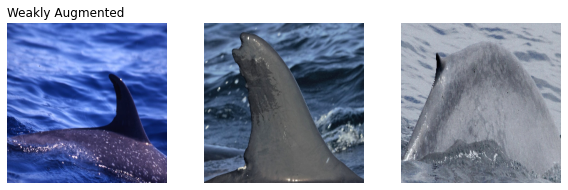

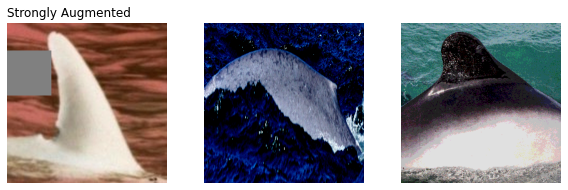

In [26]:
sample_images, sample_labels = next(iter(source_ds_w))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:3]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    if i==0:
      plt.title('Weakly Augmented', loc='left')
    plt.axis("off")

sample_images, sample_labels = next(iter(source_ds_s))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:3]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    if i==0:
      plt.title('Strongly Augmented', loc='left')
    plt.axis("off")

# Baseline model

In [11]:
K.clear_session()

reduce_lr = keras.optimizers.schedules.CosineDecay(LEARNING_RATE, TOTAL_STEPS, COSINE_ALPHA)
optimizer = keras.optimizers.Adam(LEARNING_RATE)
lr = tf.keras.callbacks.LearningRateScheduler(reduce_lr)

with strategy.scope():
  model = get_model()
  model.compile(
          optimizer=optimizer,
          loss = keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics = keras.metrics.CategoricalAccuracy(name="accuracy")
          )
    
history = model.fit(train_dataset, 
                                   epochs=EPOCHS, 
                                   validation_data=valid_dataset, 
                                   callbacks = [lr], 
                                   verbose=VERBOSE,
                                   validation_freq = 2)

Epoch 1/20
436/436 [==============================] - 614s 1s/step - loss: 1.6812 - accuracy: 0.5180 - lr: 2.0000e-04
Epoch 2/20
436/436 [==============================] - 279s 642ms/step - loss: 1.1356 - accuracy: 0.6675 - val_loss: 1.1759 - val_accuracy: 0.6583 - lr: 2.0000e-04
Epoch 3/20
436/436 [==============================] - 24s 55ms/step - loss: 0.8861 - accuracy: 0.7340 - lr: 2.0000e-04
Epoch 4/20
436/436 [==============================] - 30s 68ms/step - loss: 0.7417 - accuracy: 0.7798 - val_loss: 0.8773 - val_accuracy: 0.7281 - lr: 2.0000e-04
Epoch 5/20
436/436 [==============================] - 24s 55ms/step - loss: 0.6214 - accuracy: 0.8134 - lr: 2.0000e-04
Epoch 6/20
436/436 [==============================] - 30s 69ms/step - loss: 0.5394 - accuracy: 0.8393 - val_loss: 0.6115 - val_accuracy: 0.8139 - lr: 2.0000e-04
Epoch 7/20
436/436 [==============================] - 24s 55ms/step - loss: 0.4760 - accuracy: 0.8594 - lr: 2.0000e-04
Epoch 8/20
436/436 [====================

# Adaptive Matching

In [12]:
K.clear_session()

reduce_lr = keras.optimizers.schedules.CosineDecay(LEARNING_RATE, TOTAL_STEPS, COSINE_ALPHA)
optimizer = keras.optimizers.Adam(LEARNING_RATE)
lr = tf.keras.callbacks.LearningRateScheduler(reduce_lr)
checkpoint = tf.keras.callbacks.ModelCheckpoint('adamatch.h5', 
                                                    monitor = 'val_accuracy', 
                                                    verbose = VERBOSE, 
                                                    save_best_only = True,
                                                    save_weights_only = True, 
                                                    mode = 'max')
with strategy.scope():
  adamatch_trainer = AdaMatch(total_steps=TOTAL_STEPS)
  adamatch_trainer.compile(
          optimizer=optimizer,
          loss_func = keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
          loss_tracker = tf.keras.metrics.Mean(name="loss"),
          accuracy = keras.metrics.SparseCategoricalAccuracy(name="accuracy")
          )
    
history = adamatch_trainer.fit(total_dataset, 
                                   epochs=int(EPOCHS/2), 
                                   validation_data=valid_dataset, 
                                   callbacks = [lr], 
                                   verbose=VERBOSE,
                                   validation_freq = 2)

Epoch 1/10
87/87 [==============================] - 1275s 12s/step - loss: 5.2116 - accuracy: 0.3211 - lr: 2.0000e-04
Epoch 2/10
87/87 [==============================] - 49s 568ms/step - loss: 4.8473 - accuracy: 0.4077 - val_loss: 1.9855 - val_accuracy: 0.4519 - lr: 2.0000e-04
Epoch 3/10
87/87 [==============================] - 31s 357ms/step - loss: 4.7069 - accuracy: 0.4511 - lr: 2.0000e-04
Epoch 4/10
87/87 [==============================] - 37s 424ms/step - loss: 4.6342 - accuracy: 0.4693 - val_loss: 1.8184 - val_accuracy: 0.4975 - lr: 2.0000e-04
Epoch 5/10
87/87 [==============================] - 31s 357ms/step - loss: 4.5891 - accuracy: 0.4826 - lr: 2.0000e-04
Epoch 6/10
87/87 [==============================] - 37s 424ms/step - loss: 4.5737 - accuracy: 0.5020 - val_loss: 1.7114 - val_accuracy: 0.5361 - lr: 2.0000e-04
Epoch 7/10
87/87 [==============================] - 31s 357ms/step - loss: 4.5822 - accuracy: 0.5086 - lr: 2.0000e-04
Epoch 8/10
87/87 [==============================

# Supervised finetuning of the Adaptively matched model

In [13]:
with strategy.scope():
  finetuning_model = keras.Sequential(
    [
        tf.keras.layers.Input(shape=(RESIZE_TO, RESIZE_TO, 3)),
        adamatch_trainer.model,
        tf.keras.layers.Dense(N_CLASSES),
    ],
    name="finetuning_model",
    )
  finetuning_model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
    )
    
history = finetuning_model.fit(train_dataset, 
                                   epochs=EPOCHS, 
                                   validation_data=valid_dataset, 
                                   verbose=VERBOSE,
                                   validation_freq = 2)

Epoch 1/20
436/436 [==============================] - 63s 56ms/step - loss: 3.1046 - accuracy: 0.5080
Epoch 2/20
436/436 [==============================] - 44s 100ms/step - loss: 1.2398 - accuracy: 0.6508 - val_loss: 1.1810 - val_accuracy: 0.6722
Epoch 3/20
436/436 [==============================] - 25s 56ms/step - loss: 1.0124 - accuracy: 0.7105
Epoch 4/20
436/436 [==============================] - 31s 70ms/step - loss: 0.8565 - accuracy: 0.7518 - val_loss: 1.0134 - val_accuracy: 0.7191
Epoch 5/20
436/436 [==============================] - 25s 57ms/step - loss: 0.7488 - accuracy: 0.7842
Epoch 6/20
436/436 [==============================] - 31s 70ms/step - loss: 0.6598 - accuracy: 0.8083 - val_loss: 0.7175 - val_accuracy: 0.7883
Epoch 7/20
436/436 [==============================] - 25s 57ms/step - loss: 0.5820 - accuracy: 0.8293
Epoch 8/20
436/436 [==============================] - 31s 70ms/step - loss: 0.5263 - accuracy: 0.8469 - val_loss: 0.6565 - val_accuracy: 0.8125
Epoch 9/20
436/

In [16]:
_, model_acc = model.evaluate(test_dataset, verbose=0)
_, adamatch_acc = adamatch_trainer.evaluate(test_dataset, verbose=0)
_, fine_acc = finetuning_model.evaluate(test_dataset, verbose=0)

print_score(model_acc, 'without adaptive matching')  
print_score(adamatch_acc, 'after adaptive matching')  
print_score(fine_acc, 'after finetuning adaptive matching')  

Test accuracy without adaptive matching: 87.49877214431763%
Test accuracy after adaptive matching: 3.311452642083168%
Test accuracy after finetuning adaptive matching: 89.23287391662598%


#### Using the representations from the adaptively matched model the finetuned model performence does improve by about 2%, even when we have used data from same distribution.